In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

 # Importieren der Klassen für Lineare Regression und Standardisierung
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 

In [3]:
data_path = "data/spotify.csv"
try:
    df = pd.read_csv(data_path)
    print("Spotify dataset loaded successfully!")
except:
    import kagglehub
    import shutil
    import os
    # Download latest version
    path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
    
    # Get the first file in path
    files = os.listdir(path)
    if len(files) == 0:
        raise ValueError("No files found in the downloaded dataset.")
    # Check if the data directory exists, if not create it
    if not os.path.exists("data"):
        os.makedirs("data")

    # Move the downloaded file to the desired directory
    shutil.move(os.path.join(path, files[0]), data_path)

    print("Spotify dataset downloaded successfully!")

Spotify dataset loaded successfully!


In [4]:
country_counts = df['Country'].value_counts()
print(country_counts)

Country
Italy             34
South Africa      32
South Korea       31
Russia            31
Brazil            30
Sweden            30
Argentina         27
Spain             25
Canada            25
Indonesia         25
Mexico            24
Japan             23
France            23
Netherlands       23
India             22
United Kingdom    22
Turkey            22
Germany           20
United States     19
Australia         12
Name: count, dtype: int64


In [5]:
unique_countries_count = df['Country'].nunique()
print(f"Anzahl einzigartiger Länder: {unique_countries_count}")

Anzahl einzigartiger Länder: 20


In [27]:
album_counts = df['Album'].value_counts().reset_index()
album_counts.columns = ['Album', 'Count']
album_counts_sorted = album_counts.sort_values(by='Count', ascending=False)
album_counts_sorted.head()

,Album,Count
0,Proof,44
1,Nadie Sabe Lo Que Va a Pasar Mañana,40
2,Future Nostalgia,37
3,BORN PINK,37
4,MAÑANA SERÁ BONITO,37


In [ ]:
df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=False, dtype=bool)
df_encoded = pd.get_dummies(df_encoded, columns=['Genre'], drop_first=False, dtype=bool)
df_encoded = pd.get_dummies(df_encoded, columns=['Artist'], drop_first=False, dtype=bool)
#df_encoded = pd.get_dummies(df_encoded, columns=['Album'], drop_first=False, dtype=bool)
df_encoded = pd.get_dummies(df_encoded, columns=['Platform Type'])
df_encoded.head()

,Album,Release Year,Monthly Listeners (Millions),Total Streams (Millions),Total Hours Streamed (Millions),Avg Stream Duration (Min),Streams Last 30 Days (Millions),Skip Rate (%),Country_Argentina,Country_Australia,...,Artist_Dua Lipa,Artist_Ed Sheeran,Artist_Karol G,Artist_Olivia Rodrigo,Artist_Post Malone,Artist_SZA,Artist_Taylor Swift,Artist_The Weeknd,Platform Type_Free,Platform Type_Premium
0,1989 (Taylor's Version),2020,23.10,3695.53,14240.35,4.28,118.51,2.24,False,False,...,False,False,False,False,False,False,True,False,True,False
1,After Hours,2023,60.60,2828.16,11120.44,3.90,44.87,23.98,False,False,...,False,False,False,False,False,False,False,True,False,True
2,Austin,2019,42.84,1425.46,4177.49,4.03,19.46,4.77,False,False,...,False,False,False,False,True,False,False,False,True,False
3,Autumn Variations,2019,73.24,2704.33,12024.08,3.26,166.05,25.12,False,False,...,False,True,False,False,False,False,False,False,False,True
4,Autumn Variations,2019,7.89,3323.25,13446.32,4.47,173.43,15.82,False,False,...,False,True,False,False,False,False,False,False,True,False


In [29]:
X2 = df_encoded[df_encoded['Album'] == "Proof"].drop(columns=['Album', 'Skip Rate (%)'])
y = df_encoded['Skip Rate (%)']

In [30]:
model_reg2 = LinearRegression()
model_reg2.fit(X2, y)

print('------ Lineare Regression -----')
b0 = model_reg2.intercept_          # Ordinatenabschnitt
b1 = model_reg2.coef_[0]            # 1. Steigung
b2 = model_reg2.coef_[1]            # 2. Steigung
R2_2 = model_reg2.score(X2, y) 

# x1: Werbung, x2: Preis
print(f'Funktion via sklearn: y = {b0:.2f} + ({b1:.2f}) * Werbung + ({b2:.2f}) * Preis')

# Regressions-Koeffizienten und Bestimmheitsmaß
print(f'\nb0 = {b0:.4f}, b1 = {b1:.4f}, b2 = {b2:.4f} R^2 = {R2_2:.4f}')

ValueError: Found input variables with inconsistent numbers of samples: [44, 500]

AttributeError: 'DataFrame' object has no attribute 'Werbung'

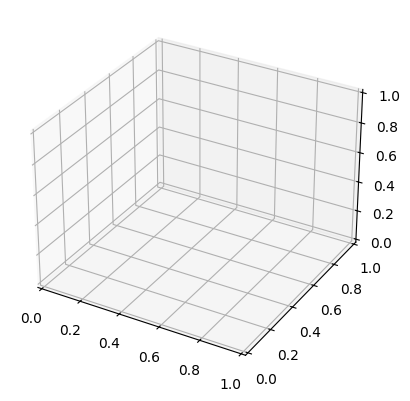

In [26]:
ax = plt.axes(projection = '3d')
ax.scatter(X2.Werbung, X2.Preis, y, c = y) # c ist die Farbe (willkürlich)

# Anmerkung: für eine Ebene reichen eigentlich 3 Punkte
xs = np.arange(200,260)
ys = np.arange(0,60)/30

Xs = pd.DataFrame( {"Werbung": xs, "Preis": ys })
zs = model_reg2.predict(Xs)

xs = np.tile(xs, (len(xs),1))
ys = np.tile(ys, (len(ys),1)).T
zs = np.tile(zs, (len(zs),1))

ax.plot_surface(xs, ys, zs, alpha = 0.5) 
plt.show()